# Classification - wildfire ignition point 

This is a binary classification problem.

It is to determine whether a point is likely to be an ignition point for wildfire. The ignition point is where the wildfire starts. This helps researchers to better simulate wildfires.

In [134]:
from pathlib import Path
import pandas as pd

In [135]:
%reload_ext autoreload
%autoreload 2

# Parameters

In [136]:
DATA_PATH = Path("data")
DATAFRAME_FOLDER_PATH = DATA_PATH / "classification_dataframe"

# Download data

In [137]:
dataframe_path = DATAFRAME_FOLDER_PATH / "dataset.csv"

In [138]:
df = pd.read_csv(dataframe_path, index_col=0)
df.head()

,Date,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,cropland,forest_deciduous_broad,forest_deciduous_needle,forest_evergreen_broad,forest_evergreen_needle,...,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,vegetation_class,Year,max_max_temp,yearly_avg_temp,ignition
0,2015-11-19,13287.682266,7211.102551,1250.000000,30196.233209,0.0,0.0,0.0,1.000000,0.0,...,225.773605,56.837185,0.297854,0.360376,1.000000,forest,2015,62.552337,14.994683,1
1,2003-02-17,8721.381771,2358.495283,250.000000,13768.169813,0.0,0.0,0.0,0.416667,0.0,...,209.708847,61.120739,0.264534,0.020176,0.833333,forest,2003,60.787457,15.053698,1
2,2012-02-26,10796.411441,0.000000,2015.564437,6254.998002,0.0,0.0,0.0,0.666667,0.0,...,76.341278,63.017559,0.208871,0.025395,1.000000,forest,2012,63.420256,15.001883,1
3,2004-11-10,8253.787010,559.016994,0.000000,37350.535471,0.0,0.0,0.0,0.000000,0.0,...,68.557823,64.673866,0.156506,0.000000,0.000000,wetland,2004,60.394119,14.850611,1
4,2003-03-19,9905.806378,0.000000,1903.943276,6427.480066,0.0,0.0,0.0,0.750000,0.0,...,316.951508,56.103680,0.208831,0.119717,0.916667,forest,2003,69.570496,NaN,1


# Structure of the dataframe


- Each row consists of an ignition or non-ignition point with the given features associated. The features were chosen as potentially influencing ignition.


- The last column named `ignition` says if the point was a real ignition point (meaning that it occurred historically), in that case the value is `1`. Otherwise, when the value is `0`, it means that it is a 'non-ignition point'.


- The columns `cropland` to `wetland` gives the ratio of each of the vegetation classes under which the ignition or non-ignition point lies. The sum of these ratios should be equal to 1. For more information refer to this website: https://lcviewer.vito.be/


- The temperatures should be in degrees celsius `(°C)`.


- The weather data come from different sources and they might have different units.

| Column name | Definition | Unit |
|--------|-----------|--------|
| `ignition`   | Target column| Boolean: {1,0} |
| `distance_{feature}` | Distance to nearest feature  |  Meters (m) |
| vegetation class: from `cropland` to `wetland`  |  Ratio of each of the vegetation classes  under which the ignition or non-ignition point lies    |  No unit (between 0 and 1)  |
| `aspect`  |  Orientation of the slope    |  Degrees (°)  |
| `elevation`  |  elevation value    |  Meters  |
| `slope`  |  Slope value    |  Degrees (°)  |
| `pop_dens`  |  Population density value    |  Persons per km2  |
| `max_temp`  |  Maximum temperature of the day    |  Degrees celsius (°C)  |
| `avg_temp`  |  Average temperature of the day   |  Degrees celsius (°C)  |
| `max_wind_vel`  |  Maximum wind velocity of the day    |  Meters per second (m/s)  |
| `avg_wind_angle`  |  Average angle of the vector wind over the day    |  Degrees (°)  |
| `avg_rel_hum`  |  Average relative humidity over the day    |  %  |
| `avg_soil`  |  Average soil moisture of the day    |  m3/m3  |
| `sum_prec`  |  Cumulative rainfall precipitation of the day    |  Millimeters (mm)  |
| `yearly_avg_temp`  |  Average temperature over the year    |  Degrees celsius (°C)  |
| `anom_{feature}`  |  Standardized anomaly of weather for the given day over the last 30 years. When the anomaly is positive, it means that the feature value is greater that the 30-year average    |  No unity |
| `forest`  |  Sum of all the columns where the names start with `forest`   |  No unit  |
| `vegetation_class`  |  Vegetation with the max occurrence in the vicinity of the ignition/non-ignition point    |  Without unit  |
| `Year`  |  Year of ignition    |  Without unit  |
| `max_max_temp`  |  Missing information    |  Missing information  |



# Solution code

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import sklearn as sk

### Data Exploration

In [140]:
## check size and balance of dataset
print('DF size:', df.shape)
print('Proportion of positives:', df.loc[df.ignition == 1].shape[0] / df.shape[0])

DF size: (22035, 42)
Proportion of positives: 0.1506693896074427


The dataset is moderately imbalanced, with only 15% of the data being positive. 

In [141]:
## check all column data types
print(df.dtypes)
df.describe()

Date                        object
distance_fire_stations     float64
distance_rivers            float64
distance_roads             float64
distance_powerlines        float64
cropland                   float64
forest_deciduous_broad     float64
forest_deciduous_needle    float64
forest_evergreen_broad     float64
forest_evergreen_needle    float64
forest_mixed               float64
forest_unknown             float64
herbaceous_vegetation      float64
moss_lichen                float64
shrubland                  float64
sprarse_vegetation         float64
urban                      float64
water                      float64
wetland                    float64
aspect                     float64
elevation                  float64
pop_dens                   float64
slope                      float64
anom_max_temp              float64
anom_max_wind_vel          float64
anom_avg_temp              float64
anom_avg_rel_hum           float64
anom_avg_soil              float64
anom_sum_prec       

,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,cropland,forest_deciduous_broad,forest_deciduous_needle,forest_evergreen_broad,forest_evergreen_needle,forest_mixed,...,avg_temp,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,Year,max_max_temp,yearly_avg_temp,ignition
count,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.0,22030.000000,22030.000000,22030.0,...,22035.000000,22035.000000,22035.000000,22035.000000,22035.000000,22035.000000,22035.000000,22035.000000,15204.000000,22035.000000
mean,23646.387792,5966.777537,5152.597702,30127.951951,0.006415,0.013557,0.0,0.326108,-4584.657286,0.0,...,158.859675,197.707583,76.109929,0.285717,1.662872,0.426235,2011.278784,59.230929,14.999755,0.150669
std,19248.657525,7515.660146,6924.754655,30099.446768,0.057848,0.088239,0.0,0.433120,20915.699938,0.0,...,135.801507,83.336828,8.027890,0.078390,3.230198,0.455856,5.693506,7.983432,0.100675,0.357734
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-100000.000000,0.0,...,-4.109107,0.792745,40.705662,0.050758,-0.000007,0.000000,2001.000000,34.109174,14.597322,0.000000
25%,9568.829605,707.106781,250.000000,8265.137627,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,7.687609,133.581253,70.623573,0.233063,0.000000,0.000000,2006.000000,53.440945,14.931427,0.000000
50%,18494.931738,2610.076627,1581.138830,20846.161854,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,276.348625,203.072937,76.005028,0.287844,0.154361,0.166667,2012.000000,58.614709,14.999861,0.000000
75%,32310.988843,8384.323013,7941.190087,41340.053217,0.000000,0.000000,0.0,0.916667,0.000000,0.0,...,280.721741,257.033798,81.626057,0.346534,1.854040,1.000000,2016.000000,64.858667,15.068628,0.000000
max,110474.261708,43784.986011,40094.419811,159274.919557,1.000000,1.000000,0.0,1.000000,0.000000,0.0,...,292.551632,358.530182,98.558968,0.501387,40.440075,1.000000,2021.000000,90.376239,15.369208,1.000000


In [142]:
df_distance = df.loc[:, df.columns.str.contains('distance_')]
df_weather = df[['max_max_temp', 'max_temp', 'avg_temp', 'max_wind_vel', 'avg_wind_angle', 'avg_rel_hum', 'yearly_avg_temp']]
df_moisture = df[['avg_rel_hum', 'avg_soil', 'sum_prec']]
df_slope = df[['aspect', 'elevation', 'slope']]

In [143]:
df_distance.describe()

,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines
count,22030.000000,22030.000000,22030.000000,22030.000000
mean,23646.387792,5966.777537,5152.597702,30127.951951
std,19248.657525,7515.660146,6924.754655,30099.446768
min,0.000000,0.000000,0.000000,0.000000
25%,9568.829605,707.106781,250.000000,8265.137627
50%,18494.931738,2610.076627,1581.138830,20846.161854
75%,32310.988843,8384.323013,7941.190087,41340.053217
max,110474.261708,43784.986011,40094.419811,159274.919557


[Text(0, 0.5, '')]

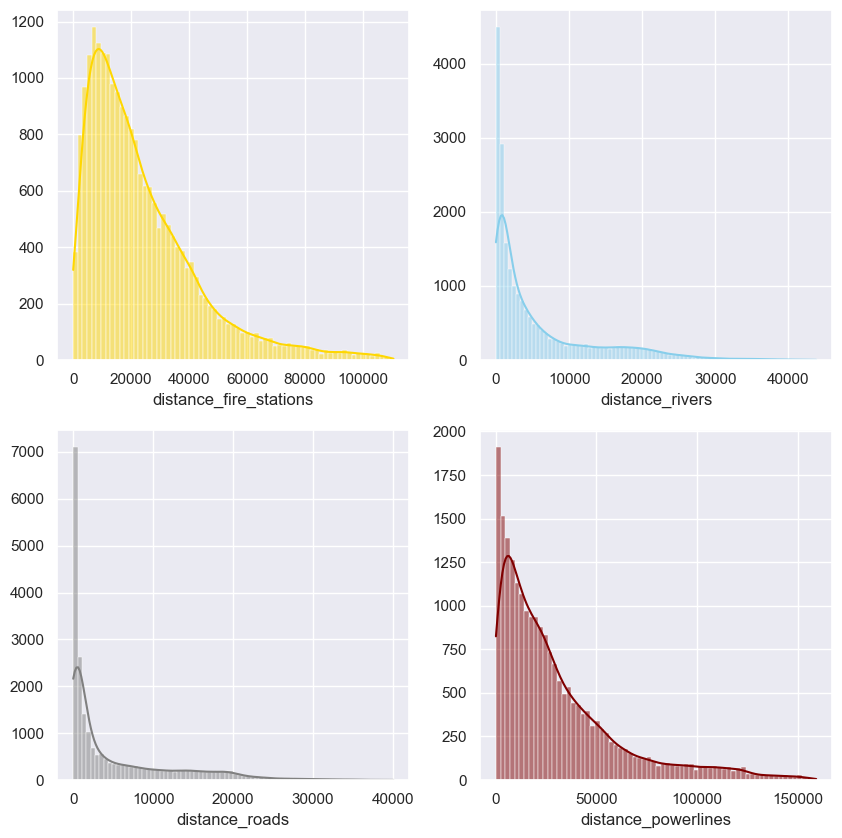

In [144]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(data=df_distance, x="distance_fire_stations", kde=True, color="gold", ax=axs[0, 0]).set(ylabel = None)
sns.histplot(data=df_distance, x="distance_rivers", kde=True, color="skyblue", ax=axs[0, 1]).set(ylabel = None)
sns.histplot(data=df_distance, x="distance_roads", kde=True, color="grey", ax=axs[1, 0]).set(ylabel = None)
sns.histplot(data=df_distance, x="distance_powerlines", kde=True, color="maroon", ax=axs[1, 1]).set(ylabel = None)

In [145]:
df_weather.describe()

,max_max_temp,max_temp,avg_temp,max_wind_vel,avg_wind_angle,avg_rel_hum,yearly_avg_temp
count,22035.000000,22035.000000,22035.000000,22035.000000,22035.000000,22035.000000,15204.000000
mean,59.230929,15.128294,158.859675,5.728723,197.707583,76.109929,14.999755
std,7.983432,4.435240,135.801507,2.483441,83.336828,8.027890,0.100675
min,34.109174,1.171763,-4.109107,0.978202,0.792745,40.705662,14.597322
25%,53.440945,11.911636,7.687609,3.858555,133.581253,70.623573,14.931427
50%,58.614709,14.785950,276.348625,5.250791,203.072937,76.005028,14.999861
75%,64.858667,18.254815,280.721741,7.180290,257.033798,81.626057,15.068628
max,90.376239,32.431244,292.551632,19.703424,358.530182,98.558968,15.369208


`avg_temp` is worth exploring as its max is 292 °C. The highest temperature ever recorded on Earth is only 56 °C.  

[Text(0, 0.5, '')]

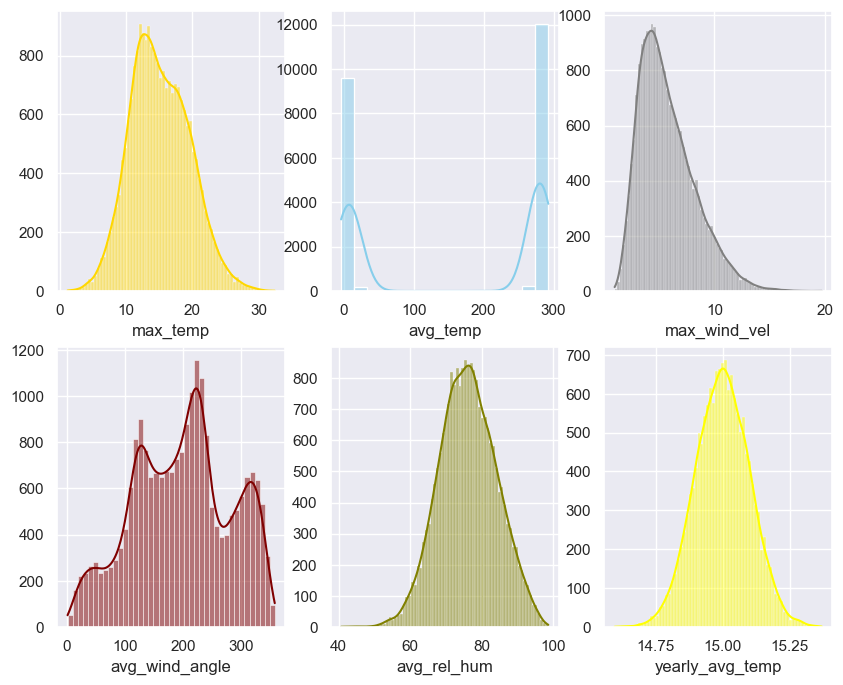

In [146]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(2, 3, figsize=(10, 8))

sns.histplot(data=df_weather, x="max_temp", kde=True, color="gold", ax=axs[0, 0]).set(ylabel = None)
sns.histplot(data=df_weather, x="avg_temp", kde=True, color="skyblue", ax=axs[0, 1]).set(ylabel = None)
sns.histplot(data=df_weather, x="max_wind_vel", kde=True, color="grey", ax=axs[0, 2]).set(ylabel = None)
sns.histplot(data=df_weather, x="avg_wind_angle", kde=True, color="maroon", ax=axs[1, 0]).set(ylabel = None)
sns.histplot(data=df_weather, x="avg_rel_hum", kde=True, color="olive", ax=axs[1, 1]).set(ylabel = None)
sns.histplot(data=df_weather, x="yearly_avg_temp", kde=True, color="yellow", ax=axs[1, 2]).set(ylabel = None)

There are more than 120k "outlier" rows with avg_temp above 250 °C. We need to treat these values.

One option is interpolating them using the mean of this column.

In [147]:
m = df.loc[np.where(df.avg_temp < 60)].avg_temp.mean()
df.avg_temp = np.where(df.avg_temp < 60, df.avg_temp, m)

df.avg_temp.describe()

count    22035.000000
mean         7.309119
std          2.196992
min         -4.109107
25%          7.309119
50%          7.309119
75%          7.309119
max         18.115168
Name: avg_temp, dtype: float64

In [148]:
df_moisture.describe()

,avg_rel_hum,avg_soil,sum_prec
count,22035.000000,22035.000000,22035.000000
mean,76.109929,0.285717,1.662872
std,8.027890,0.078390,3.230198
min,40.705662,0.050758,-0.000007
25%,70.623573,0.233063,0.000000
50%,76.005028,0.287844,0.154361
75%,81.626057,0.346534,1.854040
max,98.558968,0.501387,40.440075


**Verify whether sum of cropland to wetland colums do add up to 1**

In [173]:
veg_columns = ['cropland', 'forest_deciduous_broad', 'forest_deciduous_needle', 'forest_evergreen_broad', 
               'forest_evergreen_needle', 'forest_mixed', 'forest_unknown', 'herbaceous_vegetation', 'moss_lichen', 
               'shrubland', 'sprarse_vegetation', 'urban', 'water', 'wetland']

anomalous_rows = np.where(df[veg_columns].sum(axis = 1).round(0) != 1)[0]
print(anomalous_rows), print(anomalous_rows.size)

[   55    89   102 ... 21962 22004 22017]
1015


(None, None)

In 1,015 rows these column values do not add up to 1, indicating some data error, like the following rows:

In [174]:
print(df[veg_columns].loc[55]), print(df[veg_columns].loc[89])

cropland                        0.0
forest_deciduous_broad          0.0
forest_deciduous_needle         0.0
forest_evergreen_broad          1.0
forest_evergreen_needle   -100000.0
forest_mixed                    0.0
forest_unknown                  0.0
herbaceous_vegetation           0.0
moss_lichen                     0.0
shrubland                       0.0
sprarse_vegetation              0.0
urban                           0.0
water                           0.0
wetland                         0.0
Name: 55, dtype: float64
cropland                        0.0
forest_deciduous_broad          0.0
forest_deciduous_needle         0.0
forest_evergreen_broad          1.0
forest_evergreen_needle   -100000.0
forest_mixed                    0.0
forest_unknown                  0.0
herbaceous_vegetation           0.0
moss_lichen                     0.0
shrubland                       0.0
sprarse_vegetation              0.0
urban                           0.0
water                           0.0
wet

(None, None)

In [175]:
# replace all negative values in these columns with 0, assuming these negative values should have actually been 0s
df[veg_columns] = df[veg_columns].mask(df[veg_columns] < 0 , 0)

# check again if they add up to 1 after above replacement
df[veg_columns].loc[df[veg_columns].sum(axis = 1).round(0) != 1]

,cropland,forest_deciduous_broad,forest_deciduous_needle,forest_evergreen_broad,forest_evergreen_needle,forest_mixed,forest_unknown,herbaceous_vegetation,moss_lichen,shrubland,sprarse_vegetation,urban,water,wetland
8031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since there are only 5 data points (or 0.02% of the dataset) with NaN values for these features, we can eliminate them.

In [176]:
# keep only rows where sum of vegetation columns adds up to 1
df = df.loc[df[veg_columns].sum(axis = 1).round(0) == 1]
df.shape

(22030, 42)

The `forest` column is just a sum of the other specific-type forest columns, we can remove the others and only keep this.

In [177]:
forest_type_cols = df.columns[df.columns.str.contains('forest_')]
df.drop(columns = forest_type_cols, inplace=True)

In [178]:
# Check for number of NaNs in all columns
df.isna().sum()

Date                         0
distance_fire_stations       0
distance_rivers              0
distance_roads               0
distance_powerlines          0
cropland                     0
herbaceous_vegetation        0
moss_lichen                  0
shrubland                    0
sprarse_vegetation           0
urban                        0
water                        0
wetland                      0
aspect                       0
elevation                    0
pop_dens                     0
slope                        0
anom_max_temp                0
anom_max_wind_vel            0
anom_avg_temp                0
anom_avg_rel_hum             0
anom_avg_soil                0
anom_sum_prec                0
max_temp                     0
max_wind_vel                 0
avg_temp                     0
avg_wind_angle               0
avg_rel_hum                  0
avg_soil                     0
sum_prec                     0
forest                       0
vegetation_class            27
Year    

#### The column `yearly_avg_temp` stands out with ~30% being NaNs. 

We can use the mean of all other yearly_avg_temp of the corresponding year to replace these NaN values.

In [179]:
dict_avg_temp_by_year = df.groupby('Year').yearly_avg_temp.mean().to_dict()

# fill NaN values with lambda function using above dictionary
df.yearly_avg_temp = np.where(df.yearly_avg_temp.isnull(), df.apply(lambda x: dict_avg_temp_by_year[x.Year], axis=1), df.yearly_avg_temp)

Now onto the last column containing NaNs - `vegetation_class`.
We can drop this column since it is the simply the column with max value from among the vegetation columns like cropland, wetland, etc. Since we have available the numerical representation of each of the vegetation types in the other columns, it would be preferable to use those rather than a categorical feature. 

In [181]:
df.drop(columns = ['vegetation_class'], inplace=True)

In [182]:
anom_columns = df.columns[np.where(df.columns.str.contains('anom_'))]
df[anom_columns].describe()

,anom_max_temp,anom_max_wind_vel,anom_avg_temp,anom_avg_rel_hum,anom_avg_soil,anom_sum_prec
count,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000,22030.000000
mean,2.044283,2.202712,1.941696,2.231706,0.458170,0.040345
std,3.026246,3.320872,2.559382,2.797132,1.651076,1.042132
min,-7.159943,-7.363498,-9.482144,-9.155835,-6.903322,-3.103708
25%,-0.098111,-0.172506,0.202345,0.293489,-0.727702,-0.710843
50%,1.769070,1.964629,1.928031,2.066810,0.439978,-0.089843
75%,3.919158,4.269179,3.628303,4.100976,1.648355,0.691889
max,16.340687,22.360945,13.051181,15.005052,8.484861,4.699601


In [183]:
# proportion of anomalous weather cases which were also an ignition point
for c in anom_columns:
    print(c, df[df[c] > 0].ignition.mean())

anom_max_temp 0.1706702709344474
anom_max_wind_vel 0.1502385230159222
anom_avg_temp 0.1571604431678293
anom_avg_rel_hum 0.13213646597009757
anom_avg_soil 0.099039116289627
anom_sum_prec 0.11172857560690261


These features do not seem to be good predictors of ignition, at least by themselves, even though it might seem intuitive.

### Correlation among features

<Axes: >

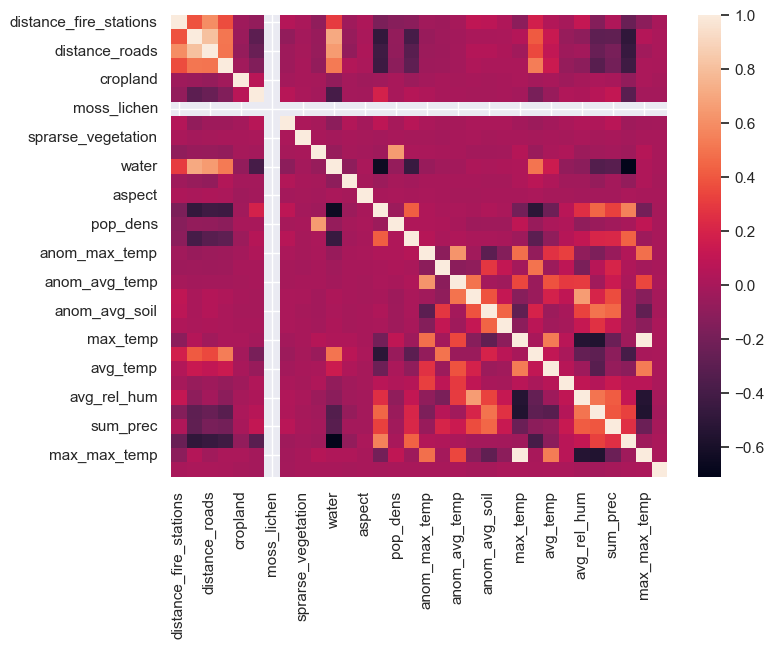

In [184]:
df_feat = df.drop(columns = ['Date', 'ignition', 'Year'])

fig, ax = pyplot.subplots(figsize = (8,6))
sns.heatmap(df_feat.corr(), ax = ax)

Looks like `moss_lichen` is full of 0s. Let's verify:

In [187]:
df.moss_lichen.sum()

0.0

Confirmed - this feature is useless.

In [188]:
df[['max_temp', 'max_max_temp']].corr()

,max_temp,max_max_temp
max_temp,1.0,1.0
max_max_temp,1.0,1.0


We should drop `max_max_temp` from our data as it is perfectly correlated with `max_temp`.

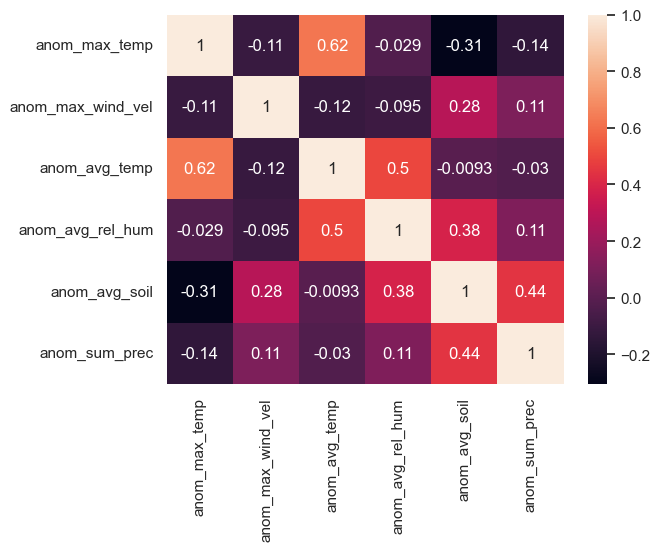

In [190]:
sns.heatmap(df[anom_columns].corr(), annot=True)
plt.show()

`anom_avg_temp` has a moderate correlation with `anom_max_temp` (0.6) and `anom_avg_rel_hum` (0.5), but nothing major.

             avg_rel_hum  avg_soil
avg_rel_hum     1.000000  0.504713
avg_soil        0.504713  1.000000


C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


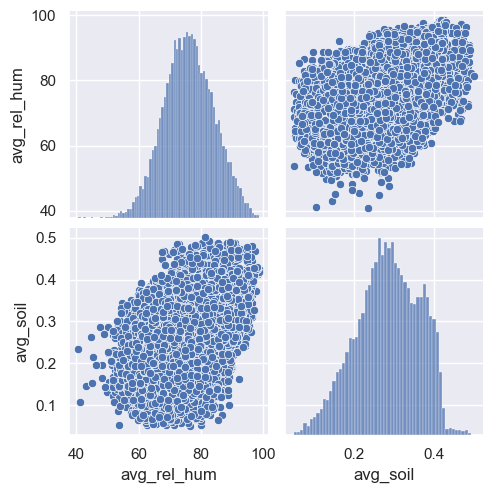

In [191]:
data = df[['avg_rel_hum', 'avg_soil']]
print(data.corr())
sns.pairplot(data)

`avg_rel_hum` and `avg_soil` have a moderate positive correlation of 0.5.

In [192]:
df[['distance_rivers', 'distance_roads']].corr()

,distance_rivers,distance_roads
distance_rivers,1.000000,0.810262
distance_roads,0.810262,1.000000


`distance_rivers` and `distance_roads` also have a high positive correlation of 0.8.

We will not drop any of the features now, but will compare the models' performance with and without dropping them later.

### Feature selection using variance thresholds 
(we keep the threshold high since we already have an imbalanced dataset of 85-15)

In [193]:
from sklearn.feature_selection import VarianceThreshold

p_list = [0.95, 0.99, 0.9999]
df_num = df.drop(columns = ['Date', 'ignition', 'Year'])

for p in p_list:
    var_thres = VarianceThreshold(threshold=(p*(1-p)))
    var_thres.fit(df_num)
    new_cols = var_thres.get_support()
    print('Var threshold: %5.4f' % (p), ', Columns dropped:', df_num.columns[new_cols == False].values, '\n')

Var threshold: 0.9500 , Columns dropped: ['cropland' 'moss_lichen' 'shrubland' 'sprarse_vegetation' 'urban'
 'wetland' 'avg_soil' 'yearly_avg_temp'] 

Var threshold: 0.9900 , Columns dropped: ['cropland' 'moss_lichen' 'shrubland' 'sprarse_vegetation' 'urban'
 'wetland' 'avg_soil' 'yearly_avg_temp'] 

Var threshold: 0.9999 , Columns dropped: ['moss_lichen' 'sprarse_vegetation'] 



We will be conservative and choose the threshold of 0.9999 and drop only the 2 columns `moss_lichen` and `sprarse_vegetation`.

Also dropping `max_max_temp` as mentioned previously, due to its perfect correlation with `max_temp`.

In [196]:
df.drop(columns=['moss_lichen', 'sprarse_vegetation', 'max_max_temp'], inplace=True)

In [197]:
# Final check of the data before we apply our classification models to make predictions
df

,Date,distance_fire_stations,distance_rivers,distance_roads,distance_powerlines,cropland,herbaceous_vegetation,shrubland,urban,water,...,max_wind_vel,avg_temp,avg_wind_angle,avg_rel_hum,avg_soil,sum_prec,forest,Year,yearly_avg_temp,ignition
0,2015-11-19,13287.682266,7211.102551,1250.000000,30196.233209,0.0,0.000000,0.0,0.0,0.0,...,5.772759,7.309119,225.773605,56.837185,0.297854,0.360376,1.000000,2015,14.994683,1
1,2003-02-17,8721.381771,2358.495283,250.000000,13768.169813,0.0,0.166667,0.0,0.0,0.0,...,5.706931,3.610960,209.708847,61.120739,0.264534,0.020176,0.833333,2003,15.053698,1
2,2012-02-26,10796.411441,0.000000,2015.564437,6254.998002,0.0,0.000000,0.0,0.0,0.0,...,5.213350,7.309119,76.341278,63.017559,0.208871,0.025395,1.000000,2012,15.001883,1
3,2004-11-10,8253.787010,559.016994,0.000000,37350.535471,0.0,0.166667,0.0,0.0,0.0,...,6.412321,5.787716,68.557823,64.673866,0.156506,0.000000,0.000000,2004,14.850611,1
4,2003-03-19,9905.806378,0.000000,1903.943276,6427.480066,0.0,0.083333,0.0,0.0,0.0,...,4.307997,5.503574,316.951508,56.103680,0.208831,0.119717,0.916667,2003,15.002539,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22030,2013-05-17,12260.199835,1820.027472,500.000000,39374.007924,0.0,0.000000,0.0,0.0,1.0,...,6.077686,7.309119,87.192940,88.675873,0.307939,0.000000,0.000000,2013,14.994649,0
22031,2017-10-22,8933.784193,3889.087297,790.569415,40380.998006,0.0,0.000000,0.0,0.0,0.0,...,5.658788,7.309119,156.162308,74.968750,0.230645,0.000000,1.000000,2017,15.045942,0
22032,2019-06-03,56560.255480,1030.776406,6388.466170,23538.532240,0.0,0.000000,0.0,0.0,0.0,...,5.383986,7.309119,307.952423,78.899803,0.234808,2.249151,1.000000,2019,14.982935,0
22033,2007-06-06,94191.294715,16839.314119,14637.281168,83236.485390,0.0,0.000000,0.0,0.0,1.0,...,10.091344,8.019510,303.465179,82.074242,0.297738,0.000000,0.000000,2007,14.897028,0


### Applying ML models

**Metric:** I have chosen the **f1 score**, as we have an imbalanced dataset and hence accuracy would not be appropriate. Additionally, I am assuming that both false positives and false negatives are equally important and so a harmonic mean of precision and recall makes sense. 

If false negatives i.e. failing to predict an ignition point where there actually is one, are more important, I would choose the f2 score, which gives more weight to the recall.

In [198]:
!pip install -r requirements/requirements_nb3.txt

Defaulting to user installation because normal site-packages is not writeable


In [199]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [200]:
def drop_correlated_columns(data, corr_threshold):
    corr_columns = set() # to store unique values of column names
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > corr_threshold:
                corr_columns.add(corr_matrix.columns[i])
    data_new = data.drop(columns = corr_columns)
    print('Columns dropped:', corr_columns)
    return data_new

In [201]:
def get_prediction(data, corr_threshold):
    
    feat = data.drop(columns = ['Date', 'ignition', 'Year'])
    labels = data.ignition
    
    # drop features with correlation above given threshold
    feat_uncorr = drop_correlated_columns(feat, corr_threshold)
    
    Model_Scores = pd.DataFrame()
    
    precision, recall, f1score, names = [], [], [], []
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state = 42)
    
    for (model, name) in models:
        print('\nApplying model {}...'.format(name))
        scores = cross_validate(model, feat_uncorr, labels, scoring=('f1_weighted', 'precision', 'recall'), cv=cv, n_jobs=None)
        precision.append(scores['test_precision'].mean())
        recall.append(scores['test_recall'].mean())
        f1score.append(scores['test_f1_weighted'].mean())
        names.append(name)
        
    Model_Scores["Classifier"] = names
    Model_Scores["Precision"] = precision
    Model_Scores["Recall"] = recall
    Model_Scores["f1 Score"] = f1score
    Model_Scores.reset_index(drop = True, inplace=True)
    
    return Model_Scores

### 1. Ensemble decision tree models

In [202]:
y = df.ignition
pos_to_neg_ratio = (y.size - y.sum()) / y.sum() # the ratio of negative samples to positive

models = [
    (RandomForestClassifier(random_state = 42, class_weight='balanced_subsample'), 'RF with balanced subsample'),
    (GradientBoostingClassifier(random_state = 42), 'GradientBoosting'),
    (AdaBoostClassifier(random_state = 42), 'AdaBoost'),
    (XGBClassifier(random_state = 42), 'XGBoost - default'),
    (XGBClassifier(random_state = 42, scale_pos_weight = pos_to_neg_ratio), 'XGBoost - with scaled_pos_weight'),
    (LGBMClassifier(random_state = 42, verbose = -1), 'LightGBM'),
    (LGBMClassifier(random_state = 42, verbose = -1, scale_pos_weight = pos_to_neg_ratio), 'LightGBM - with scaled_pos_weight')
]

In [203]:
# Predict using corr_threshold = 1 to keep all columns as ensemble decision tree models take care of multi-collinearity
DT_Scores = get_prediction(df, 1)
DT_Scores.style.background_gradient()

Columns dropped: set()

Applying model RF with balanced subsample...

Applying model GradientBoosting...

Applying model AdaBoost...

Applying model XGBoost - default...

Applying model XGBoost - with scaled_pos_weight...

Applying model LightGBM...

Applying model LightGBM - with scaled_pos_weight...


,Classifier,Precision,Recall,f1 Score
0,RF with balanced subsample,0.780642,0.435743,0.883728
1,GradientBoosting,0.695990,0.462751,0.878884
2,AdaBoost,0.627985,0.470382,0.870671
3,XGBoost - default,0.708376,0.556526,0.893361
4,XGBoost - with scaled_pos_weight,0.581754,0.745080,0.886575
5,LightGBM,0.718919,0.535843,0.892097
6,LightGBM - with scaled_pos_weight,0.510229,0.847490,0.867822


**Best model according to f1 score: XGBoost with default params, followed by default LightGBM.**

We see an *improvement in recall* and *downgrade in precision* when we tweak the class weights for XGBoost and LightGBM. 
If we only go by the recall, LightGBM with modified class weights is the best model. 

SKLearn's GradientBoostingClassifier and AdaBoost are the worst performers among these models. 

### 2. KNN

In [204]:
models = [(KNeighborsClassifier(), 'KNN')]

In [205]:
KNN_Scores = get_prediction(df, 1)
KNN_Scores

Columns dropped: set()

Applying model KNN...


,Classifier,Precision,Recall,f1 Score
0,KNN,0.575449,0.391867,0.853704


In [206]:
KNN_Scores_without_corr_feat = get_prediction(df, 0.8)
KNN_Scores_without_corr_feat

Columns dropped: {'distance_roads'}

Applying model KNN...


,Classifier,Precision,Recall,f1 Score
0,KNN,0.546456,0.351406,0.844967


**KNN underperforms compared to all the ensemble decision tree models, even after discarding features with high correlation.**

Both precision and recall are very poor.

In fact, discarding the feature `distance_roads` due to 0.8 correlation with another feature, performs worse than keeping all features.

### Conclusion

As seen above, the ensemble learning models work well for this problem although hyperparameter tuning is essential to improve performance, especially to improve recall, if the main goal is to reduce false negatives.

# END OF SCRIPT